## Installations

## Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import time
import os
import os
import re
from collections import Counter
import pickle
import lichess.api
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from warnings import filterwarnings
from random import sample
from datetime import datetime, timezone
import os
import pandas as pd
from sklearn.metrics import classification_report
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

try:
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score
except:
  import sys
  !{sys.executable} -m pip install tslearn
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from sklearn import metrics
# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")

/home/ariel/anaconda3/envs/ml/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
PROJECT_PATH="/home/ariel/Documents/chess_improments_patterns"
MAX_T=50
RISING_LABEL=1

## Methods

In [32]:
def read_file(file):
    df=pd.read_csv(file)

    return df


def get_all_players(df):
    all_whites=list(set(sorted(df["White"])))
    all_whites=sorted(all_whites)
    all_black=list(set(sorted(df["Black"])))
    all_black=sorted(all_black)
    all_players=list(set(all_whites+all_black))
    return all_players
def get_events_for_player(df,player):
    return Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Event"]))
def get_games_for_player(df,player):
    return df[(df["White"]==player)|(df["Black"]==player)]

def get_years_for_player(df,player):
    return dict(Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Year"])))
def get_years_for_player_game(df,player,game):
    return dict(Counter(list(df[((df["White"]==player)|(df["Black"]==player))&(df["Event"]==game)]["Year"])))
def get_players(df):
    w=list(df["White"])
    b=list(df["Black"])
    all=list(set((w+b)))
    return all

def get_games_for_player(df,player):
    player_black_df=df[df["Black"]==player]
    player_black_df=player_black_df[["UTCDate","BlackElo","UTCTime"]]
    player_black_df.rename(columns={'BlackElo':'Elo'},inplace=True)

    player_white_df=df[df["White"]==player]
    player_white_df=player_white_df[["UTCDate","WhiteElo","UTCTime"]]
    player_white_df.rename(columns={'WhiteElo':'Elo'},inplace=True)

    return pd.concat([player_black_df,player_white_df]).sort_values(by='UTCDate')


def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp

def get_players_atleast_x_games_type(x,game_type,df):

    df_c=(df[df["Event"]==" Blitz "])
    w=dict(df_c["White"].value_counts())
    b=dict(df_c["Black"].value_counts())
    all={}
    all=w
    for k,v in b.items():
        all[k]=all.get(k,0)+v
    h=[]
    for k,v in w.items():
        if v>200:
            h.append(k)
    len(h)

    #
    df=df[(df["White"].isin(h))|(df["Black"].isin(h))]

    #
    df1=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(h))&(~df["Black"].isin(h))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(h))&(df["Black"].isin(h))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
    return df

def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['label'], test['label']
    X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("-"*100)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    print("-"*100)
    
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }
    
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])

    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    # Create a heatmap of the summary
    plt.figure(figsize= (10,10))
    sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
    plt.show()
    

## Baseline classification(just use points no features)

In [36]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [34]:
data_dict={
    "label":[]
}
for p in player_series_labels:
    num_games=len(player_series_labels[p]['games'])
    data_dict["label"].append(int(player_series_labels[p]["label"][0]==1))
    for i in range(0,min(num_games,MAX_T)):
        data_dict["t="+str(i)+""]=data_dict.get("t="+str(i),[])
        data_dict["t="+str(i)+""].append(player_series_labels[p]['games'][i])

df=pd.DataFrame.from_dict(data_dict)

In [35]:
df

,label,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,...,t=40,t=41,t=42,t=43,t=44,t=45,t=46,t=47,t=48,t=49
0,0,1634,1653,1651,1644,1643,1653,1651,1634,1633,...,1581,1573,1578,1576,1573,1569,1565,1558,1556,1554
1,0,1406,1399,1408,1417,1426,1434,1441,1448,1455,...,1423,1432,1442,1438,1434,1446,1456,1446,1457,1452
2,0,1619,1619,1615,1609,1612,1621,1623,1625,1615,...,1591,1600,1605,1615,1605,1595,1599,1604,1596,1605
3,0,1661,1655,1649,1643,1651,1640,1648,1656,1665,...,1668,1675,1665,1671,1662,1665,1668,1674,1676,1667
4,0,1764,1755,1753,1747,1740,1747,1740,1733,1728,...,1783,1810,1787,1766,1751,1738,1734,1740,1739,1756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5925,0,1352,1343,1338,1359,1351,1349,1339,1331,1348,...,1324,1322,1318,1306,1330,1325,1320,1309,1300,1297
5926,0,1544,1535,1543,1550,1557,1564,1554,1561,1568,...,1556,1547,1554,1561,1568,1558,1549,1556,1547,1538
5927,0,1262,1235,1258,1250,1248,1243,1272,1262,1250,...,1263,1259,1252,1255,1269,1264,1259,1258,1257,1258
5928,0,1353,1352,1352,1351,1351,1351,1351,1338,1338,...,1305,1297,1328,1327,1326,1324,1324,1324,1323,1323


In [37]:
models=[]

#### logistic regression

----------------------------------------------------------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6973018549747049
roc_auc_score: 0.6119061949664504
precision_score: 0.5833333333333334
f1_score: 0.4381846635367762
----------------------------------------------------------------------------------------------------


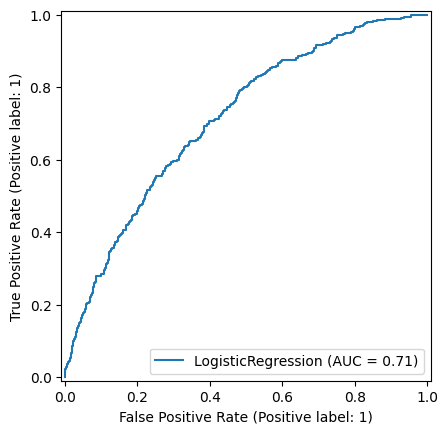

In [38]:
from sklearn.linear_model import LogisticRegression
models.append(classify(df,0.2,LogisticRegression(),"logistic regression"))

#### Support vector machines

----------------------------------------------------------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6863406408094435
roc_auc_score: 0.56254654586134
precision_score: 0.6396396396396397
f1_score: 0.27626459143968873
----------------------------------------------------------------------------------------------------


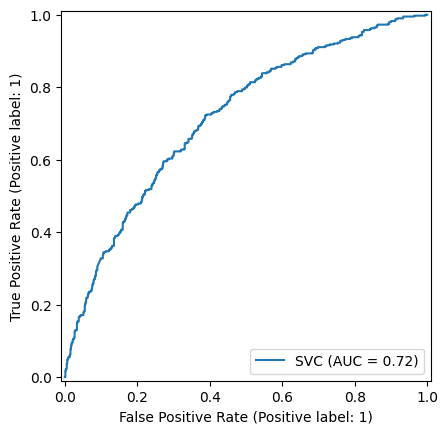

In [39]:
from sklearn.svm import SVC
models.append(classify(df,0.2,SVC(probability =True),"Support vector machine"))

#### Random Forrest

----------------------------------------------------------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.684654300168634
roc_auc_score: 0.6151317432567431
precision_score: 0.5760869565217391
f1_score: 0.4595375722543353
----------------------------------------------------------------------------------------------------


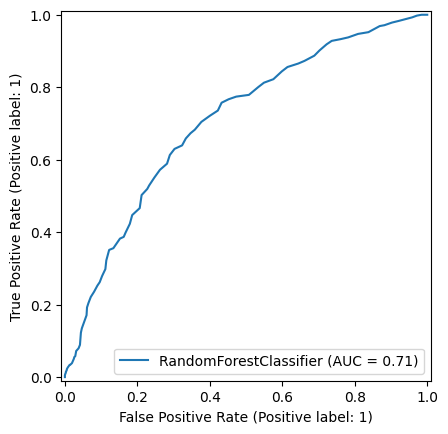

In [40]:
from sklearn.ensemble import RandomForestClassifier 
models.append(classify(df,0.2,RandomForestClassifier(n_estimators=100, random_state=42),"basic random forrest"))

#### Decision Tree

----------------------------------------------------------------------------------------------------
Model name: decision tree
accuracy_score: 0.6053962900505903
roc_auc_score: 0.5690122377622377
precision_score: 0.4386792452830189
f1_score: 0.44285714285714284
----------------------------------------------------------------------------------------------------


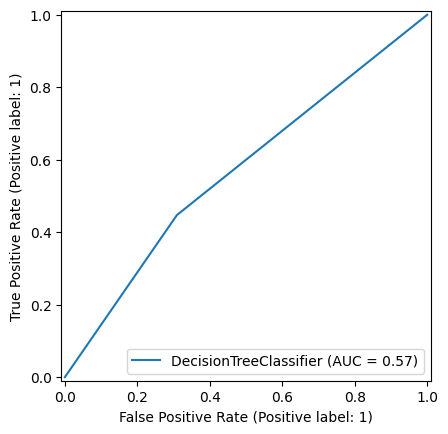

In [41]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
models.append(classify(df,0.2,DecisionTreeClassifier(random_state=42),"decision tree"))

#### Gaussian Naive Bayes

----------------------------------------------------------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5809443507588533
roc_auc_score: 0.5472363437001594
precision_score: 0.41043083900226757
f1_score: 0.4214202561117579
----------------------------------------------------------------------------------------------------


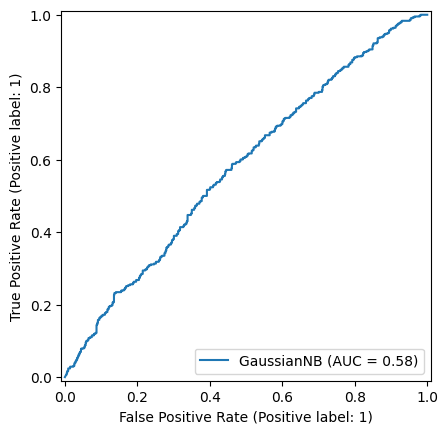

In [42]:
from sklearn.naive_bayes import GaussianNB  # For Gaussian Naive Bayes
models.append(classify(df,0.2,GaussianNB(),"Gaussian Naive Bayes"))

#### KNN

----------------------------------------------------------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.642495784148398
roc_auc_score: 0.5371384885851532
precision_score: 0.5
f1_score: 0.2508833922261484
----------------------------------------------------------------------------------------------------


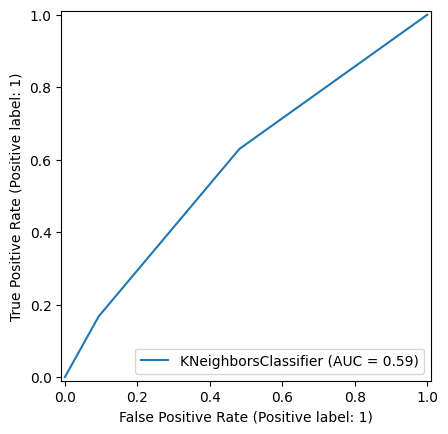

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
models.append(classify(df,0.2,KNeighborsClassifier(2),"KNeighborsClassifier"))

#### AdaBoostClassifier

----------------------------------------------------------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6930860033726813
roc_auc_score: 0.5747536945812808
precision_score: 0.675
f1_score: 0.30798479087452474
----------------------------------------------------------------------------------------------------


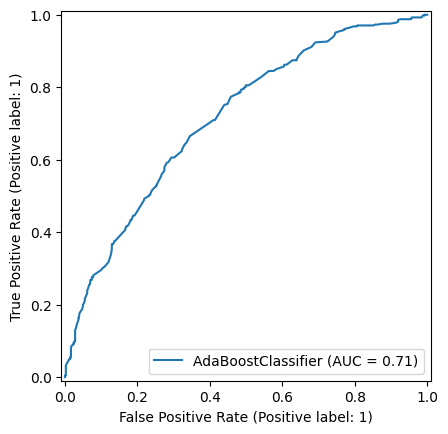

In [44]:
models.append(classify(df,0.2,AdaBoostClassifier(),"AdaBoostClassifier"))

#### CatBoostClassifier

Learning rate set to 0.020028
0:	learn: 0.6902036	total: 2.27ms	remaining: 2.27s
1:	learn: 0.6871218	total: 3.87ms	remaining: 1.93s
2:	learn: 0.6844473	total: 5.55ms	remaining: 1.84s
3:	learn: 0.6818355	total: 7.01ms	remaining: 1.75s
4:	learn: 0.6792476	total: 8.38ms	remaining: 1.67s
5:	learn: 0.6768749	total: 9.92ms	remaining: 1.64s
6:	learn: 0.6744644	total: 11.4ms	remaining: 1.61s
7:	learn: 0.6723912	total: 12.8ms	remaining: 1.58s
8:	learn: 0.6703587	total: 14.1ms	remaining: 1.55s
9:	learn: 0.6682644	total: 15.5ms	remaining: 1.53s
10:	learn: 0.6662278	total: 16.8ms	remaining: 1.51s
11:	learn: 0.6642967	total: 18.1ms	remaining: 1.49s
12:	learn: 0.6623273	total: 19.5ms	remaining: 1.48s
13:	learn: 0.6607257	total: 20.9ms	remaining: 1.47s
14:	learn: 0.6589616	total: 22.2ms	remaining: 1.46s
15:	learn: 0.6573984	total: 23.5ms	remaining: 1.44s
16:	learn: 0.6559557	total: 24.9ms	remaining: 1.44s
17:	learn: 0.6543238	total: 26.2ms	remaining: 1.43s
18:	learn: 0.6528497	total: 27.7ms	remaining

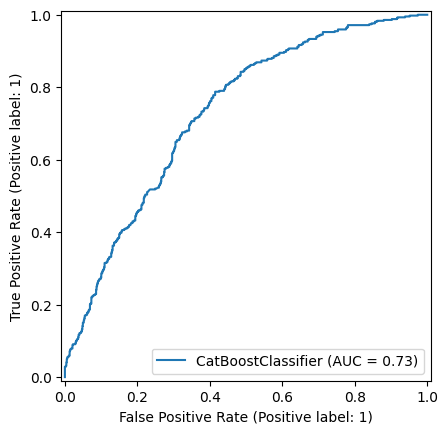

In [45]:
models.append(classify(df,0.2,CatBoostClassifier(),"CatBoostClassifier"))

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6686340640809444
roc_auc_score: 0.6021861810594205
precision_score: 0.5196078431372549
f1_score: 0.4472573839662447
----------------------------------------------------------------------------------------------------


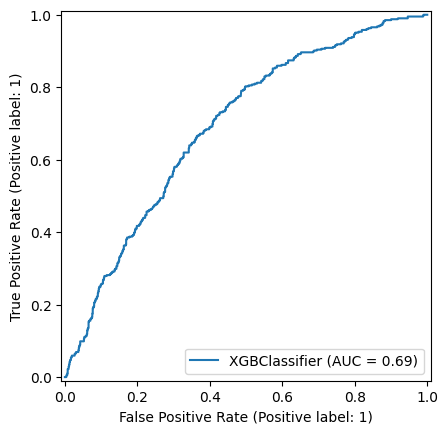

In [46]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### LGBM

[LightGBM] [Info] Number of positive: 1615, number of negative: 3129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 4744, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340430 -> initscore=-0.661379
[LightGBM] [Info] Start training from score -0.661379
----------------------------------------------------------------------------------------------------
Model name: LGBMClassifier
accuracy_score: 0.693929173693086
roc_auc_score: 0.6311184973332302
precision_score: 0.6083916083916084
f1_score: 0.48945147679324896
----------------------------------------------------------------------------------------------------


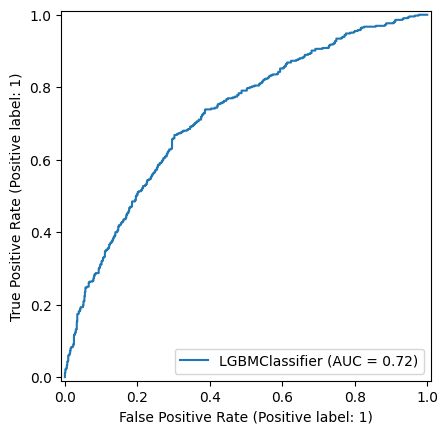

In [47]:
models.append(classify(df,0.2,LGBMClassifier(),"LGBMClassifier"))

#### Comparision

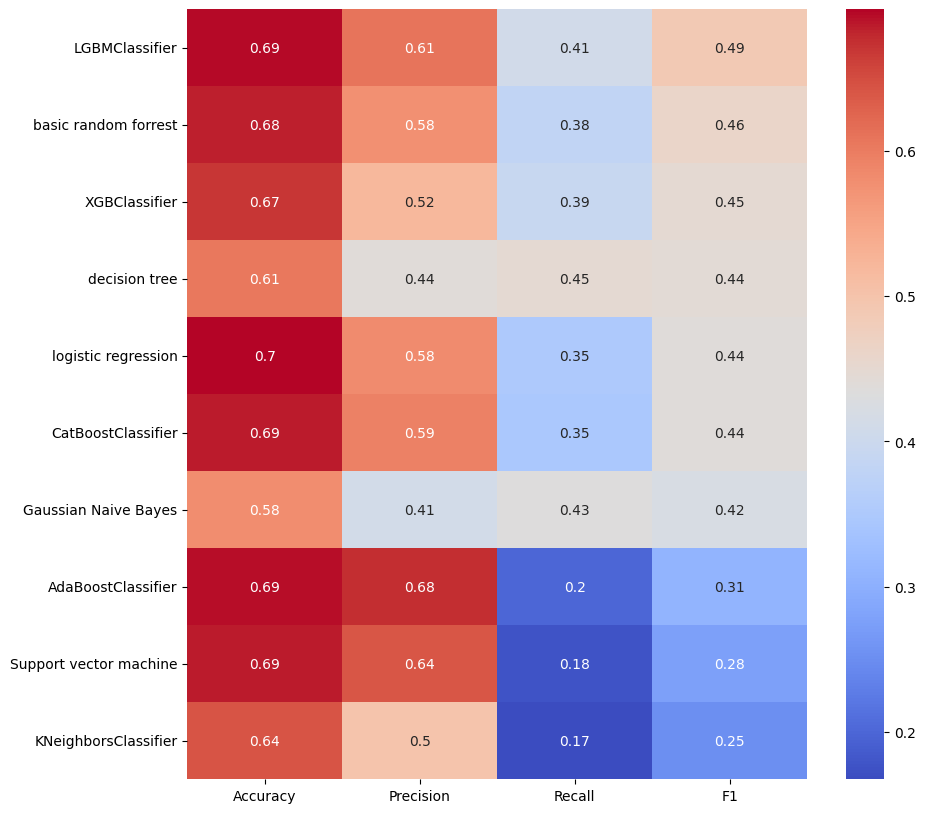

In [48]:
compare_model_results(models)

##  find features

In [ ]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [4]:
chunksize = 10 ** 7
rich_players_data={p:[] for p in players}

with pd.read_csv(f"{PROJECT_PATH}/data/fics/dataset_raw/chess-games-rated-standard-filtered.csv", chunksize=chunksize) as reader:
    for chunk in reader:
        print("read")
        chunk=chunk[(chunk["White"].isin(players))|(chunk["Black"].isin(players))]
        chunk["Year"]=chunk["Date"].apply(lambda r:int(r.split(".")[0]))
        chunk["Month"]=chunk["Date"].apply(lambda r:int(r.split(".")[1]))
        chunk["Day"]=chunk["Date"].apply(lambda r:int(r.split(".")[2]))
        chunk["Timestamp"]=(chunk["Date"]+" "+chunk["Time"]).apply(lambda r:date_to_num(r))
        for p in tqdm(players):
            ts=player_series_labels[p]['ts']
            cond_1=(chunk["Timestamp"]>=min(ts))
            cond_2=(chunk["Timestamp"]<=max(ts))
            cond_3=((chunk["White"]==p)|(chunk["Black"]==p))
            chunk_filtered=chunk[cond_1&cond_2&cond_3]
            rich_players_data[p].append(chunk_filtered)

for p in players:
    rich_players_data[p]=pd.concat(rich_players_data[p])

with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean_rich.pkl", 'wb+') as f:
    pickle.dump(rich_players_data,f)

NameError: name 'players' is not defined

In [6]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean_rich.pkl", 'rb') as f:
    rich_players_data=pickle.load(f)



In [7]:
with open(f"{PROJECT_PATH}/data/fics/dataset_raw/player_series_labels_v2_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [8]:
# player_series_labels

for p in list(rich_players_data.keys()): 
    curr=rich_players_data[p]
    curr=curr.sort_values(by=["Timestamp"]).reset_index()
    curr=curr[curr.index<MAX_T]
    rich_players_data[p]=curr

    
    

In [9]:
example=rich_players_data[list(rich_players_data.keys())[0]]

In [10]:
def get_freq(my_str,c):
    return ( sum([int(s==c) for s in my_str]))

In [11]:
features_dict={
    'white_to_black_ratio':[],
    'label':[],
    'player_elo_mean':[],
    'opponent_elo_mean':[],
    'elo_diff_mean':[],
    'total_won':[],
    'total_lost':[],
    'total_draw':[],
    'avg_number_of_moves':[]

}

for p in list(rich_players_data.keys()): 
    
    # count
    curr=rich_players_data[p]
    # print(curr.columns)
    curr_w=curr[curr["White"]==p]
    curr_b=curr[curr["Black"]==p]
    total_number_of_moves_w=sum(curr_w.Moves.apply(lambda c:get_freq(c,"|")))
    total_number_of_moves_b=sum(curr_b.Moves.apply(lambda c:get_freq(c,"|")))

    avg__number_of_moves=(total_number_of_moves_w+total_number_of_moves_b)/len(curr)
    features_dict["avg_number_of_moves"].append(avg__number_of_moves)




    total_won_as_w=len(curr[(curr["Result"]=="1-0")&(curr["White"]==p)])
    total_lost_as_w=len(curr[(curr["Result"]=="0-1")&(curr["White"]==p)])
    total_won_as_b=len(curr[(curr["Result"]=="0-1")&(curr["Black"]==p)])
    total_lost_as_b=len(curr[(curr["Result"]=="1-0")&(curr["Black"]==p)])
    total_won=total_won_as_w+total_won_as_b
    total_lost=total_lost_as_w+total_lost_as_b
    total_draw=len(curr)-total_won-total_lost
    features_dict["total_won"].append(total_won)
    features_dict["total_lost"].append(total_lost)
    features_dict["total_draw"].append(total_draw)
    total_number_of_moves=sum(curr.Moves.apply(lambda c:get_freq(c,"|")))
    avg__number_of_moves=total_number_of_moves/len(curr)

    #
    black_freq=dict(Counter(curr["Black"]))
    white_freq=dict(Counter(curr["White"]))
    result_freq=dict(Counter(curr["Result"]))
    white_to_black_ratio=white_freq.get(p,0)/(MAX_T)
    features_dict["white_to_black_ratio"].append(white_to_black_ratio)
    
    #
    player_elo=list(curr[curr["White"]==p]["WhiteElo"])+list(curr[curr["Black"]==p]["BlackElo"])
    opponent_elo=list(curr[curr["White"]!=p]["WhiteElo"])+list(curr[curr["Black"]!=p]["BlackElo"])
    player_elo_mean=np.mean(player_elo)
    opponent_elo_mean=np.mean(opponent_elo)
    elo_diff=[r["WhiteElo"]-r["BlackElo"] for (_,r) in curr.iterrows()]
    elo_diff_mean=sum(elo_diff)/len(curr)
    #
    features_dict["elo_diff_mean"].append(elo_diff_mean)
    features_dict["player_elo_mean"].append(player_elo_mean)
    features_dict["opponent_elo_mean"].append(opponent_elo_mean)



    # label
    label=player_series_labels[p]['label'][0]
    label=int(player_series_labels[p]["label"][0]==RISING_LABEL)
    features_dict["label"].append(label)


df=pd.DataFrame.from_dict(features_dict)
df

,white_to_black_ratio,label,player_elo_mean,opponent_elo_mean,elo_diff_mean,total_won,total_lost,total_draw,avg_number_of_moves
0,0.50,0,1625.56,1569.84,26.88,32,18,0,46.70
1,0.48,0,1580.46,1687.72,8.26,19,30,1,42.18
2,0.46,0,1465.70,1480.20,-21.66,20,29,1,48.28
3,0.46,1,1746.82,1561.62,-14.76,37,9,4,68.76
4,0.50,0,1630.56,1703.84,-10.16,16,29,5,66.16
...,...,...,...,...,...,...,...,...,...
5925,0.50,0,1754.94,1762.34,5.88,24,22,4,76.20
5926,0.54,0,1639.98,1592.58,1.52,26,21,3,55.12
5927,0.50,0,1558.88,1523.56,2.60,25,24,1,53.38
5928,0.48,1,1732.62,1220.80,-0.14,47,3,0,61.24


In [12]:
models=[]

#### logistic regression

----------------------------------------------------------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6812816188870152
roc_auc_score: 0.5718097812421423
precision_score: 0.6095890410958904
f1_score: 0.32014388489208634
----------------------------------------------------------------------------------------------------


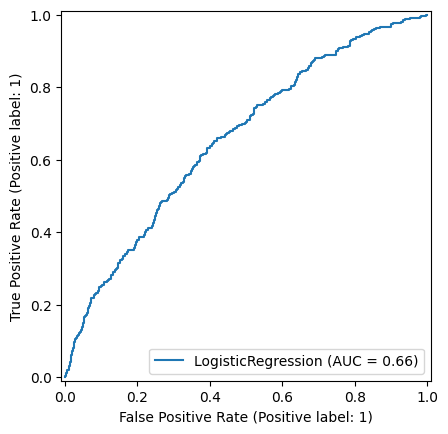

In [13]:
from sklearn.linear_model import LogisticRegression
models.append(classify(df,0.2,LogisticRegression(),"logistic regression"))

#### Support vector machines

----------------------------------------------------------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6720067453625632
roc_auc_score: 0.5
precision_score: 0.0
f1_score: 0.0
----------------------------------------------------------------------------------------------------


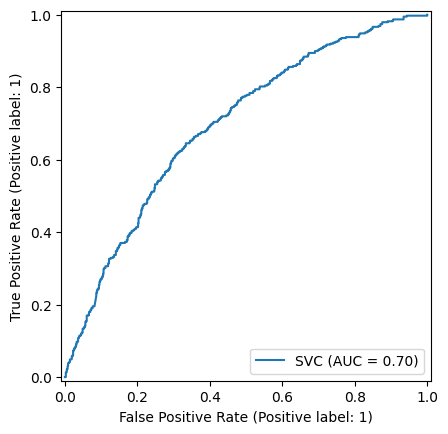

In [14]:
from sklearn.svm import SVC
models.append(classify(df,0.2,SVC(probability =True),"Support vector machine"))

#### Random Forrest

----------------------------------------------------------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.6391231028667791
roc_auc_score: 0.5417785563815255
precision_score: 0.4756756756756757
f1_score: 0.2913907284768212
----------------------------------------------------------------------------------------------------


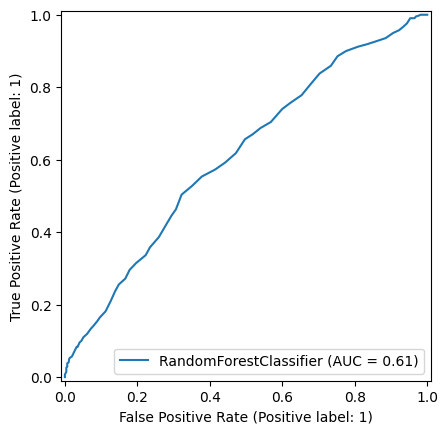

In [15]:
from sklearn.ensemble import RandomForestClassifier 
models.append(classify(df,0.2,RandomForestClassifier(n_estimators=100, random_state=42),"basic random forrest"))

#### Decision Tree

----------------------------------------------------------------------------------------------------
Model name: decision tree
accuracy_score: 0.5893760539629005
roc_auc_score: 0.5579203765873595
precision_score: 0.44755244755244755
f1_score: 0.44087256027554533
----------------------------------------------------------------------------------------------------


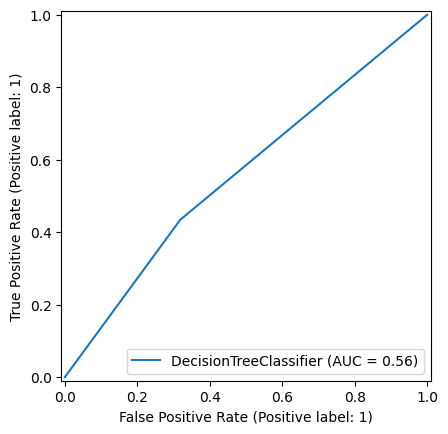

In [16]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
models.append(classify(df,0.2,DecisionTreeClassifier(random_state=42),"decision tree"))

#### Gaussian Naive Bayes

----------------------------------------------------------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.6408094435075885
roc_auc_score: 0.5062295061450277
precision_score: 0.4032258064516129
f1_score: 0.10504201680672269
----------------------------------------------------------------------------------------------------


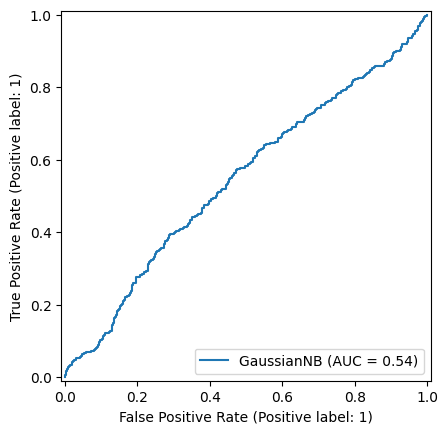

In [17]:
from sklearn.naive_bayes import GaussianNB  # For Gaussian Naive Bayes
models.append(classify(df,0.2,GaussianNB(),"Gaussian Naive Bayes"))

#### KNN

----------------------------------------------------------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.6374367622259697
roc_auc_score: 0.5132455485490096
precision_score: 0.39097744360902253
f1_score: 0.1947565543071161
----------------------------------------------------------------------------------------------------


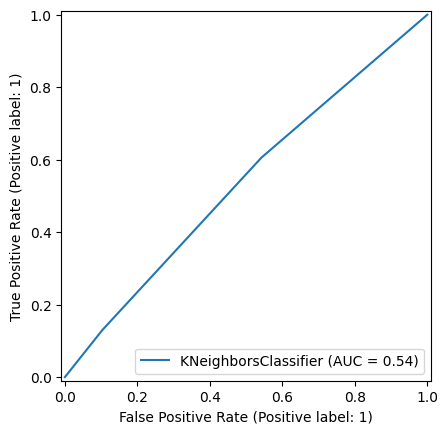

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
models.append(classify(df,0.2,KNeighborsClassifier(2),"KNeighborsClassifier"))

#### AdaBoostClassifier

----------------------------------------------------------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6795952782462057
roc_auc_score: 0.5463125625426879
precision_score: 0.6206896551724138
f1_score: 0.22131147540983606
----------------------------------------------------------------------------------------------------


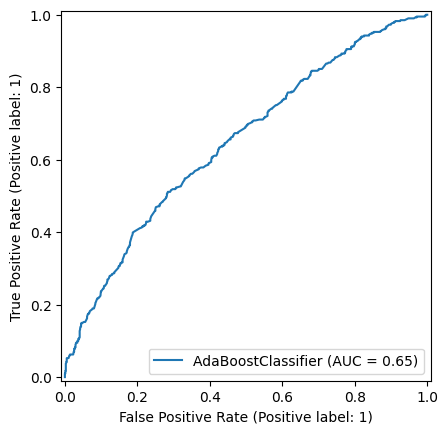

In [19]:
models.append(classify(df,0.2,AdaBoostClassifier(),"AdaBoostClassifier"))

#### CatBoostClassifier

Learning rate set to 0.020028
0:	learn: 0.6903621	total: 48.3ms	remaining: 48.3s
1:	learn: 0.6879902	total: 49.9ms	remaining: 24.9s
2:	learn: 0.6856336	total: 50.8ms	remaining: 16.9s
3:	learn: 0.6835120	total: 51.6ms	remaining: 12.9s
4:	learn: 0.6814248	total: 52.7ms	remaining: 10.5s
5:	learn: 0.6792722	total: 53.5ms	remaining: 8.87s
6:	learn: 0.6770875	total: 57.4ms	remaining: 8.15s
7:	learn: 0.6749515	total: 58.7ms	remaining: 7.28s
8:	learn: 0.6729750	total: 60ms	remaining: 6.61s
9:	learn: 0.6708741	total: 61.2ms	remaining: 6.06s
10:	learn: 0.6688988	total: 62.3ms	remaining: 5.6s
11:	learn: 0.6672999	total: 63.2ms	remaining: 5.21s
12:	learn: 0.6657721	total: 64.4ms	remaining: 4.89s
13:	learn: 0.6640341	total: 65.3ms	remaining: 4.6s
14:	learn: 0.6625827	total: 66.4ms	remaining: 4.36s
15:	learn: 0.6610038	total: 67.3ms	remaining: 4.14s
16:	learn: 0.6594118	total: 68.3ms	remaining: 3.95s
17:	learn: 0.6582013	total: 69.4ms	remaining: 3.79s
18:	learn: 0.6567603	total: 70.3ms	remaining: 3.

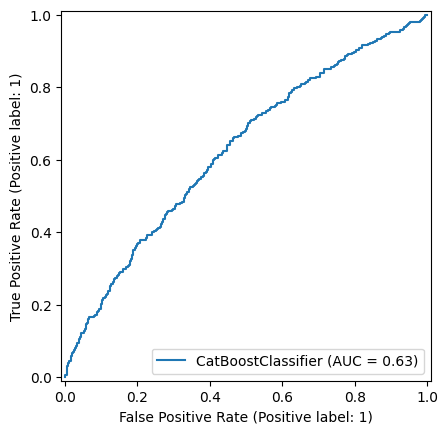

In [20]:
models.append(classify(df,0.2,CatBoostClassifier(),"CatBoostClassifier"))

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.6602023608768971
roc_auc_score: 0.5832926585066708
precision_score: 0.5210727969348659
f1_score: 0.40296296296296297
----------------------------------------------------------------------------------------------------


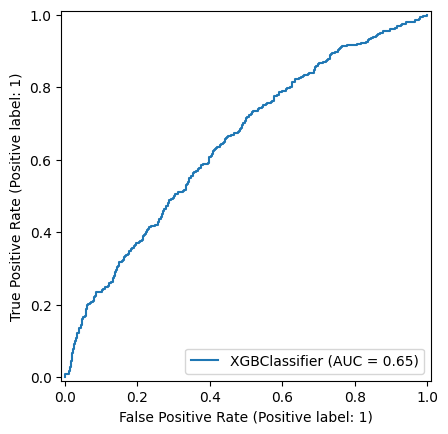

In [22]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### LGBM

[LightGBM] [Info] Number of positive: 1626, number of negative: 3118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 4744, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342749 -> initscore=-0.651069
[LightGBM] [Info] Start training from score -0.651069
----------------------------------------------------------------------------------------------------
Model name: LGBMClassifier
accuracy_score: 0.654300168634064
roc_auc_score: 0.5658775750294109
precision_score: 0.509009009009009
f1_score: 0.3553459119496855
----------------------------------------------------------------------------------------------------


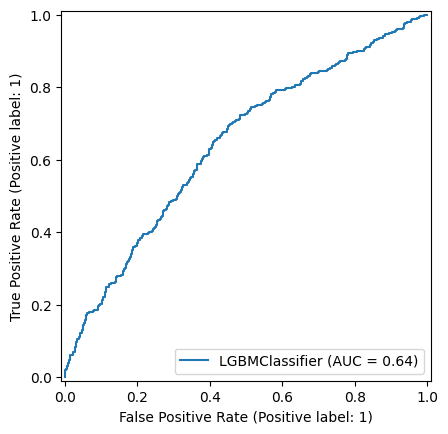

In [23]:
models.append(classify(df,0.2,LGBMClassifier(),"LGBMClassifier"))

#### Comparision

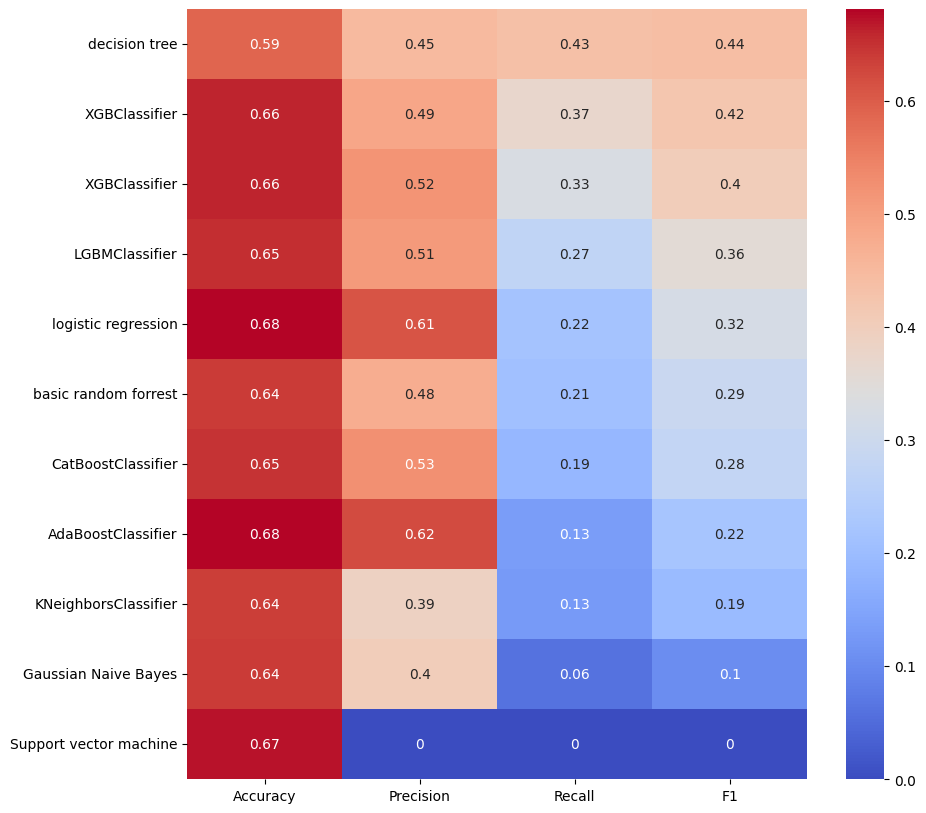

In [33]:
compare_model_results(models)